In [1]:
import re
import warnings
import calendar
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz

%pylab inline
import seaborn as sns
sns.set_style('whitegrid')



__kaggle_username = ""
__kaggle_key = ""
os.environ['KAGGLE_USERNAME'] = __kaggle_username
os.environ['KAGGLE_KEY'] = __kaggle_key

!kaggle competitions download -c flight-delays-fall-2018


############# ONLY FOR COLAB ################
import os 

try:
    from catboost import CatBoostClassifier, Pool, cv
    import shap
except ModuleNotFoundError:
    !pip install shap --quiet
    !pip install catboost --quiet
    from catboost import CatBoostClassifier, Pool, cv
    import shap
    
from google.colab import drive

drive.mount('/content/gdrive')

Populating the interactive namespace from numpy and matplotlib
401 - Unauthorized


In [2]:
TRAIN = 'flight_delays_train.csv'
TEST = 'flight_delays_test.csv'



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
%%writefile bootpython.py

# MODEL/FILE SAVE/LOAD
import pickle
from google.colab import drive, files


drive.mount('/content/gdrive')

class StormColab:
    
    '''
    Saves and loads files and pickle dumps from ~/Colab Notebooks folder !only!
    Chosen only folder with .ipynb for sake of simpliness 

    METHOD      PARAMETERS

    model_save  (model, file_name: str, params:dict=None, annotation: str=None) 
    model_load  (file_name: str) 
    file_save   (file_name: str) 
    file_load   (file_name: str) 

    '''

    @staticmethod
    def model_save(model, file_name: str, params:dict=None, annot: str=None) -> None:
        data_path = '/content/gdrive/My Drive/Colab Notebooks/' + file_name
        data_to_save = [model, params, annot]

        with open(data_path, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f'saved at location {data_path}')

    @staticmethod
    def model_load(file_name: str) -> None:
        file_name = '/content/gdrive/My Drive/Colab Notebooks/' + file_name
        with open(file_name,'rb+') as f:
            return pickle.load(f)

    @staticmethod
    def file_save(file_name: str) -> None:
        data_path = '/content/gdrive/My Drive/Colab Notebooks/' + file_name
        with open(file_name, 'r+') as f_to_save:
            with open(data_path, 'w+') as f_to_write:
                f_to_write.write(f_to_save.read())
        print(f'saved at location {data_path}')

    @staticmethod
    def file_load(file_name: str) -> None:
        data_path = '/content/gdrive/My Drive/Colab Notebooks/' + file_name
        with open(data_path, 'r+') as f:
            with open(file_name, 'w+') as wf:
                wf.write(f.read())
        print(f'loaded file {file_name}')


# Yandex RandomForest GradientBoosting algorithm
# CATBOOST SHAP
try:
    from catboost import CatBoostClassifier, Pool, cv
    import shap
except ModuleNotFoundError:
    !pip install shap  --quiet
    !pip install catboost --quiet
    from catboost import CatBoostClassifier, Pool, cv
    import shap

from google.colab import drive
drive.mount('/content/gdrive')


# KAGGLE CREDENTIALS
import os 
__kaggle_username = ""
# !!! CATION
## REMOVE BEFORE PUSH TO GIT!
__kaggle_key = ""
os.environ['KAGGLE_USERNAME'] = __kaggle_username
os.environ['KAGGLE_KEY'] = __kaggle_key


def submit_kaggle(sample_sub, name='flight_pred.csv'):
    sample_sub = pd.read_csv('sample_submission.csv', index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv(name)
    print(f"{name} writed")
    
# extract all zip-files into working dir
def extract_all_zip() -> None:
    from zipfile import ZipFile
    files = list()
    print('Extrated:')
    for f in os.listdir():
        if f.endswith('.zip'):
            files.append(f)
            ZipFile(f, 'r').extractall()
            print(f)        
    print(f'Extraction complete at location {os.getcwd()}')

Writing bootpython.py


In [64]:
StormColab.file_save('bootpython.py')

saved at location /content/gdrive/My Drive/Colab Notebooks/bootpython.py


In [4]:
extract_all_zip()

train_df = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)

def reset():
    global train_df
    global test_df
    train_df = pd.read_csv(TRAIN)
    test_df = pd.read_csv(TEST)

Extrated:
flight_delays_test.csv.zip
flight_delays_train.csv.zip
sample_submission.csv.zip
Extraction complete at location /content


In [ ]:
def plot_by_target(df, col, hue="dep_delayed_15min", plot=sns.countplot, sharey=False):
    grid = sns.FacetGrid(df, col=hue, height=4.5, aspect=1, sharey=sharey)
    grid.map(plot, col)
    grid.set_xticklabels(rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


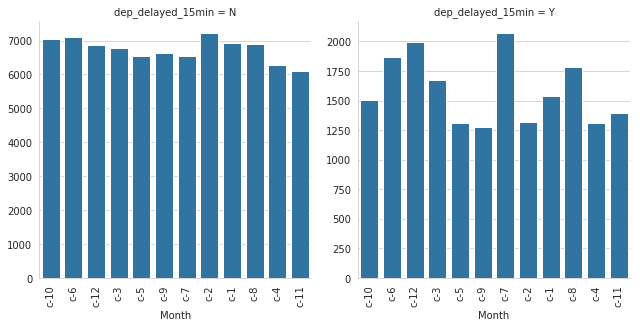

In [67]:
plot_by_target(train_df, 'Month')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


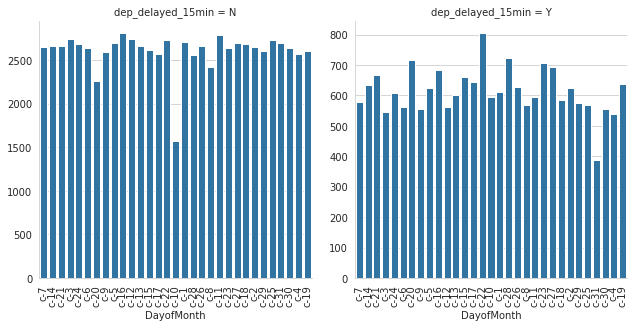

In [68]:
plot_by_target(train_df, 'DayofMonth')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


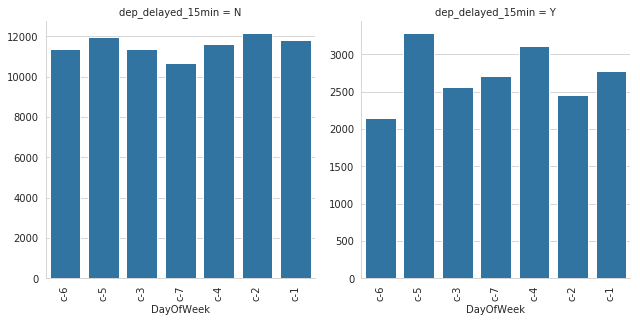

In [69]:
plot_by_target(train_df, 'DayOfWeek')

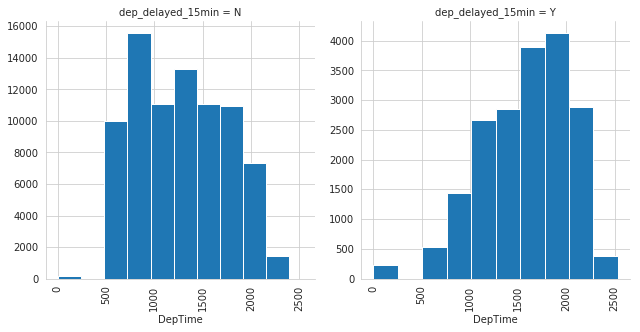

In [70]:
plot_by_target(train_df, 'DepTime', plot=plt.hist)

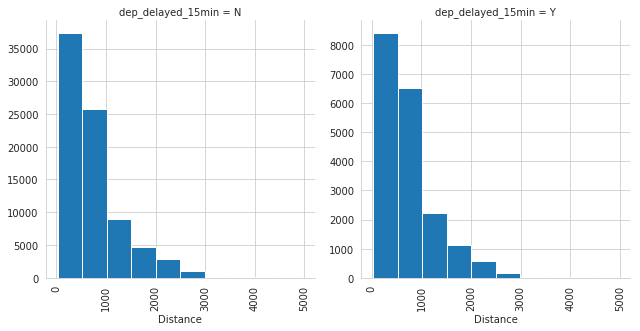

In [71]:
plot_by_target(train_df, 'Distance', plot=plt.hist)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


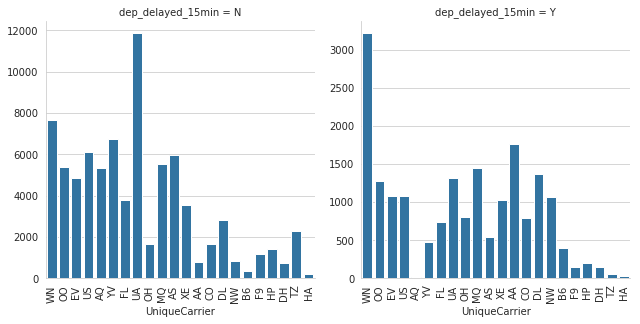

In [72]:
plot_by_target(train_df, 'UniqueCarrier')

In [2]:
# %%writefile work_with_features.py

class view_dataframe_stats:

    def __init__(self, df):
        self.df = df
        self.cols = df.columns
        self.unique_vals = [df[col].unique() for col in self.cols]

    def view_unique_vals(self): 
        view_df = pd.DataFrame.from_dict(dict(zip(self.cols, self.unique_vals)),
                                         orient='index')
        view_df.fillna(" ", inplace=True)
        return view_df.T
        
    def unique_len(self):
        unique_len = [len(val) for val in self.unique_vals]
        return dict(zip(self.cols, unique_len))


def time_class(time):
    if  500 <= time < 1200:
        return 'morning'
    elif 1200 <= time < 1700:
        return 'afternoon'
    elif 1700 <= time < 2100:
        return 'evening'
    return 'night' 

def season_class(month):
    if 3 <= month < 6:
        return 'spring'
    elif 6 <= month < 9:
        return 'summer'
    elif 9 <= month < 12:
        return 'autumn'
    return 'winter'

def distance_class(distance):
    if distance < 150:
        return 'short'
    elif 150 <= distance < 317:
        return 'middle'
    elif 317 <= distance < 575:
        return 'long'
    elif 575 <= distance:
        return 'extreme long'

Writing work_with_features.py


In [ ]:
# StormColab.file_save('work_with_features.py')

In [ ]:
def time_features_extraction(df):
    pattern = re.compile("[0-9]+")
    month = df.Month.map(lambda x: pattern.search(x)[0]).astype('int8')

    df['Hour'] = df.DepTime // 100   # removing minutes 
    df['Minutes'] = df.DepTime % 100 # removing hours
    df['PartOfDay'] = df.DepTime.map(time_class)

    df['DayofMonth'] = df.DayofMonth.map(lambda x: pattern.search(x)[0])
    df['Month'] = month.map(lambda x: calendar.month_name[x])
    df['DayMonth'] = df.DayofMonth + " " +  df.Month
    
    # calendar.day_name got digits of week from 0 to 6 but 1-7 occur
    df['DayOfWeek'] = df.DayOfWeek.map(lambda x: pattern.search(x)[0]) \
                      .astype('int8').map(lambda x: x - 1) \
                      .map(lambda x: calendar.day_name[x])

    df['Season'] = month.map(season_class)
    return df


def feature_generation(df):
    df['flight'] = df['Origin'] + '--' + train_df['Dest']
    df['flight_h'] = df['flight'] + '-' + (df['Hour']).astype('str')

    df['dist_cls'] = df['Distance'].map(distance_class)

    df['carrier_origin'] = df['UniqueCarrier'] + '--' + df['Origin']
    df['carrier_h'] = df['UniqueCarrier'] + '--' + (df['Hour']).astype('str')
    df['carrier_dow'] = df['UniqueCarrier'] + '--' + df['DayOfWeek']

    df['origin_h'] = df['Origin'] + '--' + (df['Hour']).astype('str')
    df['origin_m'] = df['Origin'] + '--' + df['Minutes'].astype('str') 

    df['Distance'] = df['Distance'] // 10

    df.drop(['DayofMonth', 'Month','Season', 'dist_cls'], axis=1, inplace=True)
    return df

In [76]:
train_vds = view_dataframe_stats(train_df)
test_vds = view_dataframe_stats(test_df)
train_vds.unique_len()

{'DayOfWeek': 7,
 'DayofMonth': 31,
 'DepTime': 1300,
 'Dest': 289,
 'Distance': 1310,
 'Month': 12,
 'Origin': 289,
 'UniqueCarrier': 22,
 'dep_delayed_15min': 2}

In [77]:
test_vds.unique_len()

{'DayOfWeek': 7,
 'DayofMonth': 31,
 'DepTime': 1287,
 'Dest': 298,
 'Distance': 1331,
 'Month': 12,
 'Origin': 300,
 'UniqueCarrier': 20}

In [78]:
train_df.head(2)

Month DayofMonth DayOfWeek  DepTime  ... Origin Dest Distance  dep_delayed_15min
0   c-8       c-21       c-7     1934  ...    ATL  DFW      732                  N
1   c-4       c-20       c-3     1548  ...    PIT  MCO      834                  N

[2 rows x 9 columns]

In [7]:
reset()

# Time extraction
train_df = time_features_extraction(train_df)
test_df = time_features_extraction(test_df)

# Feature generation
train_df = feature_generation(train_df)
test_df = feature_generation(test_df)

train_df.dep_delayed_15min = train_df.dep_delayed_15min.map({"Y":1, "N":0})

print(train_df.shape[1])
train_df.head(2)

18


DayOfWeek  DepTime UniqueCarrier  ...    carrier_dow origin_h  origin_m
0     Sunday     1934            AA  ...     AA--Sunday  ATL--19   ATL--34
1  Wednesday     1548            US  ...  US--Wednesday  PIT--15   PIT--48

[2 rows x 18 columns]

In [ ]:
# # STRATIFIED SHUFFLE SPLIT/ KFold
# SEED = 17

# sss = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)


# X = train_df.drop('dep_delayed_15min', axis=1)
# y = train_df['dep_delayed_15min']

# sss.get_n_splits(X,y)

# for train_idx, test_idx in sss.split(X,y):
#     X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx] 

# cat_features = cat_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]

In [ ]:
# # NORMAL
SEED = 17
X_train, X_valid = train_test_split(train_df.drop('dep_delayed_15min',axis=1), 
                                    random_state=SEED, test_size=0.3)
y_train, y_valid = train_test_split(train_df.dep_delayed_15min, 
                                    random_state=SEED, test_size=0.3)


cat_features = cat_feat_idx = np.where(train_df.drop('dep_delayed_15min', 
                                                     axis=1).dtypes == 'object')[0]

In [ ]:

params = {'iterations':25000,
          'loss_function': 'Logloss',
          'verbose':1000,
          'random_seed': SEED,
          'eval_metric':'AUC',
          'task_type': 'GPU',
          'cat_features': cat_features,
          'depth':6,
          'bootstrap_type': 'Bayesian',
          'grow_policy': 'SymmetricTree',
          'early_stopping_rounds':150
          }


# "min_data_in_leaf":50
# 'max_leaves':50 # for 'Lossguide' param
# 'grow_policy': 'SymmetricTree', 'Depthwise', 'Lossguide'
# 'bootstrap_type': 'Bayesian', 'Bernoulli', 'MVS', 'Poisson', 'No'

model = CatBoostClassifier(**params)
model.fit(train_df.drop('dep_delayed_15min',axis=1), train_df['dep_delayed_15min'],
        #   eval_set=(train_df.drop('dep_delayed_15min',axis=1), train_df['dep_delayed_15min']),
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.003504
0:	learn: 0.7240031	total: 63.8ms	remaining: 26m 36s
1000:	learn: 0.8035504	total: 52.8s	remaining: 21m 6s
2000:	learn: 0.8202139	total: 1m 45s	remaining: 20m 12s
3000:	learn: 0.8299867	total: 2m 37s	remaining: 19m 16s
4000:	learn: 0.8384629	total: 3m 29s	remaining: 18m 21s
5000:	learn: 0.8445437	total: 4m 22s	remaining: 17m 27s
6000:	learn: 0.8491421	total: 5m 13s	remaining: 16m 33s
7000:	learn: 0.8529579	total: 6m 5s	remaining: 15m 39s
8000:	learn: 0.8560634	total: 6m 56s	remaining: 14m 44s
9000:	learn: 0.8588256	total: 7m 47s	remaining: 13m 50s
10000:	learn: 0.8613901	total: 8m 38s	remaining: 12m 56s
11000:	learn: 0.8638092	total: 9m 29s	remaining: 12m 4s
12000:	learn: 0.8660760	total: 10m 19s	remaining: 11m 11s
13000:	learn: 0.8681667	total: 11m 9s	remaining: 10m 18s
14000:	learn: 0.8701886	total: 12m	remaining: 9m 26s
15000:	learn: 0.8721265	total: 12m 51s	remaining: 8m 34s
16000:	learn: 0.8739716	total: 13m 41s	remaining: 7m 42s
17000:	learn: 0.87580

In [ ]:
print(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.9897896742821649
0.9893976982434116


In [ ]:
# SAVE MODEL
StormColab.model_save(model, 'FlightDelay_CatBst_88_nohp.pkl', params=params, annot='did 0.75+ on KAGGGLE cant right now test on kaggle(reached limit)')

In [ ]:
# LOAD MODEL
model_last = StormColab.model_load('FlightDelay_CatBst_81_nohp.pkl')

In [ ]:
# DROP FEATURES AFTER TRAIN
threshold = 2

droping = features[features['Importances'] < threshold]['Feature Id'].tolist()
print(droping)

train_df.drop(droping, axis=1, inplace=True)
test_df.drop(droping, axis=1, inplace=True)

In [ ]:
features = model.get_feature_importance(prettified=True)
features

Feature Id  Importances
0         Minutes    15.551973
1      flight_dep    12.669396
2     carrier_dep     8.865844
3         DepTime     7.423896
4          flight     6.159592
5        DayMonth     5.885797
6      origin_dep     5.216733
7        tech_bay     5.206161
8            Dest     4.963330
9       PartOfDay     4.572195
10     origin_min     4.314356
11  UniqueCarrier     4.001136
12       Distance     3.564854
13    carrier_dow     3.157379
14           Hour     3.065622
15      DayOfWeek     2.837885
16         Origin     2.543848

In [ ]:
sns.distplot(model.get_feature_importance(prettified=True))

In [ ]:
model_last.get_feature_importance(prettified=True)

In [ ]:
# SUBMIT TO KAGGLE
ctb_test_pred = model.predict_proba(test_df)[:, 1]
submit_kaggle(ctb_test_pred)

!kaggle competitions submit -c flight-delays-fall-2018  -f flight_pred.csv -m 'after tune lr, depth and feature removal'

flight_pred.csv writed
100% 2.43M/2.43M [00:05<00:00, 483kB/s]
Successfully submitted to mlcourse.ai: Flight delays 

In [10]:
depth_params = [2,3,5,10]
leaf_params = [0, 1, 2, 5, 10, 15, 20]
learning_params = [1, 0.2, 0.1, 0.01, 0.001]

init_params = {'iterations':500,
            'loss_function': 'Logloss',
            'verbose':False,
            'random_seed': SEED,
            'eval_metric':'AUC',
            'task_type': 'GPU',
            'cat_features': cat_features
            }

def list_search(param_list:list, param_name:str, init_params:dict) ->[list,list]:
    train_score = list()
    valid_score = list()

    for par in param_list:
        init_params[param_name] =  par
        # print(init_params)
        model = CatBoostClassifier(**init_params)
        model.fit(X_train, y_train,
                eval_set=(X_valid, y_valid),
                use_best_model=True,
                plot=True)
        valid_score.append(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))
        train_score.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    return train_score, valid_score

depth_train_score, depth_valid_score = list_search(depth_params, 'depth', init_params)
leaf_train_score, leaf_valid_score = list_search(leaf_params, 'l2_leaf_reg', init_params)
lr_train_score, lr_valid_score = list_search(lr_params, 'learning_rate', init_params)

Output hidden; open in https://colab.research.google.com to view.

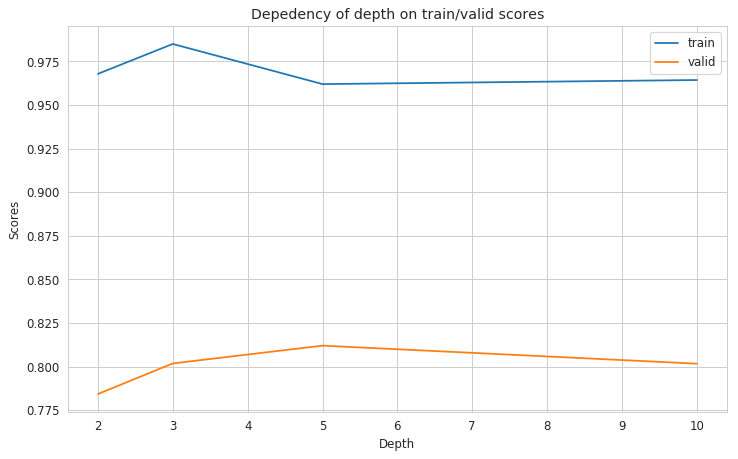

In [11]:
plt.figure(dpi=85, figsize=(10,6))
plt.plot(depth_params, depth_train_score)
plt.plot(depth_params, depth_valid_score)
plt.xlabel('Depth')
plt.ylabel('Scores')
plt.legend(['train', 'valid'])
plt.title("Depedency of depth on train/valid scores")
plt.grid(True)
plt.show()

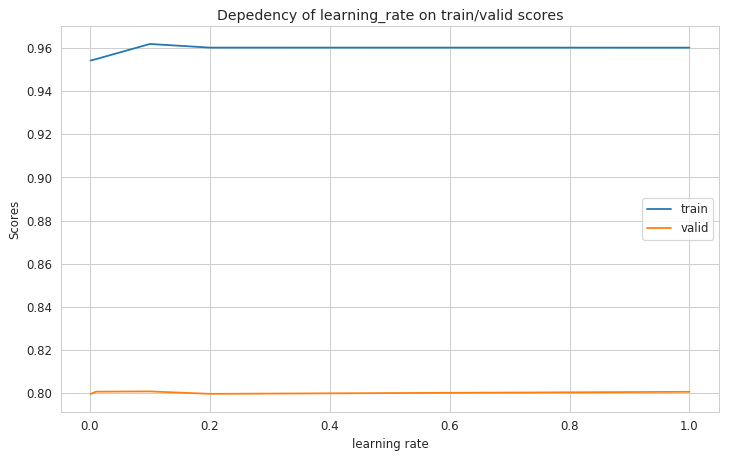

In [87]:
plt.figure(dpi=85, figsize=(10,6))
plt.plot(learning_params, lr_train_score)
plt.plot(learning_params, lr_valid_score)
plt.xlabel('learning rate')
plt.ylabel('Scores')
plt.legend(['train', 'valid'])
plt.title("Depedency of learning_rate on train/valid scores")
plt.grid(True)
plt.show()

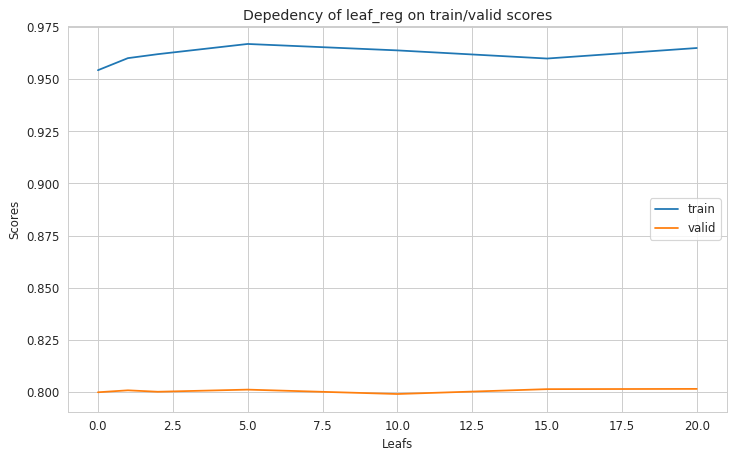

In [89]:
plt.figure(dpi=85, figsize=(10,6))
plt.plot(leaf_params, leaf_train_score)
plt.plot(leaf_params, leaf_valid_score)
plt.xlabel('Leafs')
plt.ylabel('Scores')
plt.legend(['train', 'valid'])
plt.title("Depedency of leaf_reg on train/valid scores")
plt.grid(True)
plt.show()